<pre>
1. Download all the data in this folder https://drive.google.com/open?id=1Z4TyI7FcFVEx8qdl4jO9qxvxaqLSqoEu. it contains two file both images and labels. The label file list the images and their categories in the following format:
            <b>path/to/the/image.tif,category</b>
            
    where the categories are numbered 0 to 15, in the following order:

    <b>0 letter
    1 form
    2 email
    3 handwritten
    4 advertisement
    5 scientific report
    6 scientific publication
    7 specification
    8 file folder
    9 news article
    10 budget
    11 invoice
    12 presentation
    13 questionnaire
    14 resume
    15 memo</b>
    
2. On this image data, you have to train 3 types of models as given below. You have to split the data into Train and Validation data.

3. Try not to load all the images into memory, use the gernarators that we have given the reference notebooks to load the batch of images only during the train data.
or you can use this method also
<a href='https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1'>https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1</a>

<a href='https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c'>https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c</a>


4. You are free to choose Learning rate, optimizer, loss function, image augmentation, any hyperparameters. but you have to use the same architechture what we are asking below. 

5. Use tensorboard for every model and analyse your gradients. (you need to upload the screenshots for each model for evaluation)

Note: fit_genarator() method will have problems with the tensorboard histograms, try to debug it, if you could not do use histgrams=0 i.e don't include histograms, check the documentation of tensorboard for more information. 

6. You can check about Transfer Learning in this link - <a href='https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html'>https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html</a>
</pre>

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import warnings 
import random as rn
warnings.filterwarnings("ignore") 

In [12]:
data = pd.read_csv('labels_final.csv',dtype=str)
data.head(5)

,path,label
0,imagesv/v/o/h/voh71d00/509132755+-2755.tif,3
1,imagesl/l/x/t/lxt19d00/502213303.tif,3
2,imagesx/x/e/d/xed05a00/2075325674.tif,2
3,imageso/o/j/b/ojb60d00/517511301+-1301.tif,3
4,imagesq/q/z/k/qzk17e00/2031320195.tif,7


In [13]:
data['label'].value_counts()

0     3016
13    3007
12    3006
14    3006
3     3005
8     3003
9     3002
10    3002
7     3000
5     2999
15    2996
1     2994
4     2994
2     2993
11    2992
6     2985
Name: label, dtype: int64

Since all class labels have similar number of datapoints It is a balanced dataset

In [14]:
dir_path='data_final'

In [15]:
from keras_preprocessing.image import ImageDataGenerator

In [16]:

imageflow = ImageDataGenerator( rescale=1./255.,
                                validation_split=0.25,                  ## Data augmentation
                                rotation_range=40,
                                width_shift_range=0.3,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,)

train_generator=imageflow.flow_from_dataframe(dataframe=data,directory=dir_path,x_col="path",y_col="label",subset="training",
batch_size=32,seed=42,shuffle=True,class_mode='categorical',target_size=(224,224))

valid_generator=imageflow.flow_from_dataframe(dataframe=data,directory=dir_path,x_col="path",y_col="label",subset="validation",
batch_size=32,seed=42,shuffle=True,class_mode='categorical',target_size=(224,224))

Found 36000 validated image filenames belonging to 16 classes.
Found 12000 validated image filenames belonging to 16 classes.


In [66]:
##Checking time taken to load images. 
import time
start = time.time()
total_batches = 0

batches = 0
per_batch = 32
for x_batch, y_batch in train_generator:
    batches += 1
    if batches >= 36000/per_batch:
        total_batches = total_batches + batches
        break 
end = time.time()
duration = end-start
print("{} batches: {} s".format(total_batches, duration))
print("{:0.5f} Images/s".format(per_batch*total_batches/duration))

1125 batches: 1384.3742151260376 s
26.00453 Images/s


In [67]:
##Checking time taken to load images. 
import time
start = time.time()
total_batches = 0

batches = 0
per_batch = 32
for x_batch, y_batch in valid_generator:
    batches += 1
    if batches >= 12000/per_batch:
        total_batches = total_batches + batches
        break 
end = time.time()
duration = end-start
print("{} batches: {} s".format(total_batches, duration))
print("{:0.5f} Images/s".format(per_batch*total_batches/duration))

375 batches: 195.81710648536682 s
61.28167 Images/s




### Model-1

<pre>
1. Use <a href='https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16'>VGG-16</a> pretrained network without Fully Connected layers and initilize all the weights with Imagenet trained weights. 
2. After VGG-16 network without FC layers, add a new Conv block ( 1 Conv layer and 1 Maxpooling ), 2 FC layers and a output layer to classify 16 classes. You are free to choose any hyperparameters/parameters of conv block, FC layers, output layer. 
3. Final architecture will be <b>INPUT --> VGG-16 without Top layers(FC) --> Conv Layer --> Maxpool Layer --> 2 FC layers --> Output Layer</b>
4. Train only new Conv block, FC layers, output layer. Don't train the VGG-16 network. 

</pre>

In [17]:
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model

tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)
## loading vgg16 model without FC layers

vgg16 = VGG16(weights='imagenet',include_top=False,input_shape = (224,224, 3))

## freezing the model
vgg16.trainable = False

vgg16_op = vgg16.output
conv_layer = Conv2D(filters=128, kernel_size=7, activation='relu',padding='valid')(vgg16_op)
maxpool_layer = MaxPooling2D(pool_size=1,strides=2)(conv_layer)
flatten = Flatten()(maxpool_layer)
FC_1 = Dense(2048,activation='relu')(flatten)
FC_2 = Dense(1024,activation='relu')(FC_1)
output_layer = Dense(16,activation='softmax')(FC_2)

final_model=Model(inputs = vgg16.input, outputs = output_layer)
final_model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

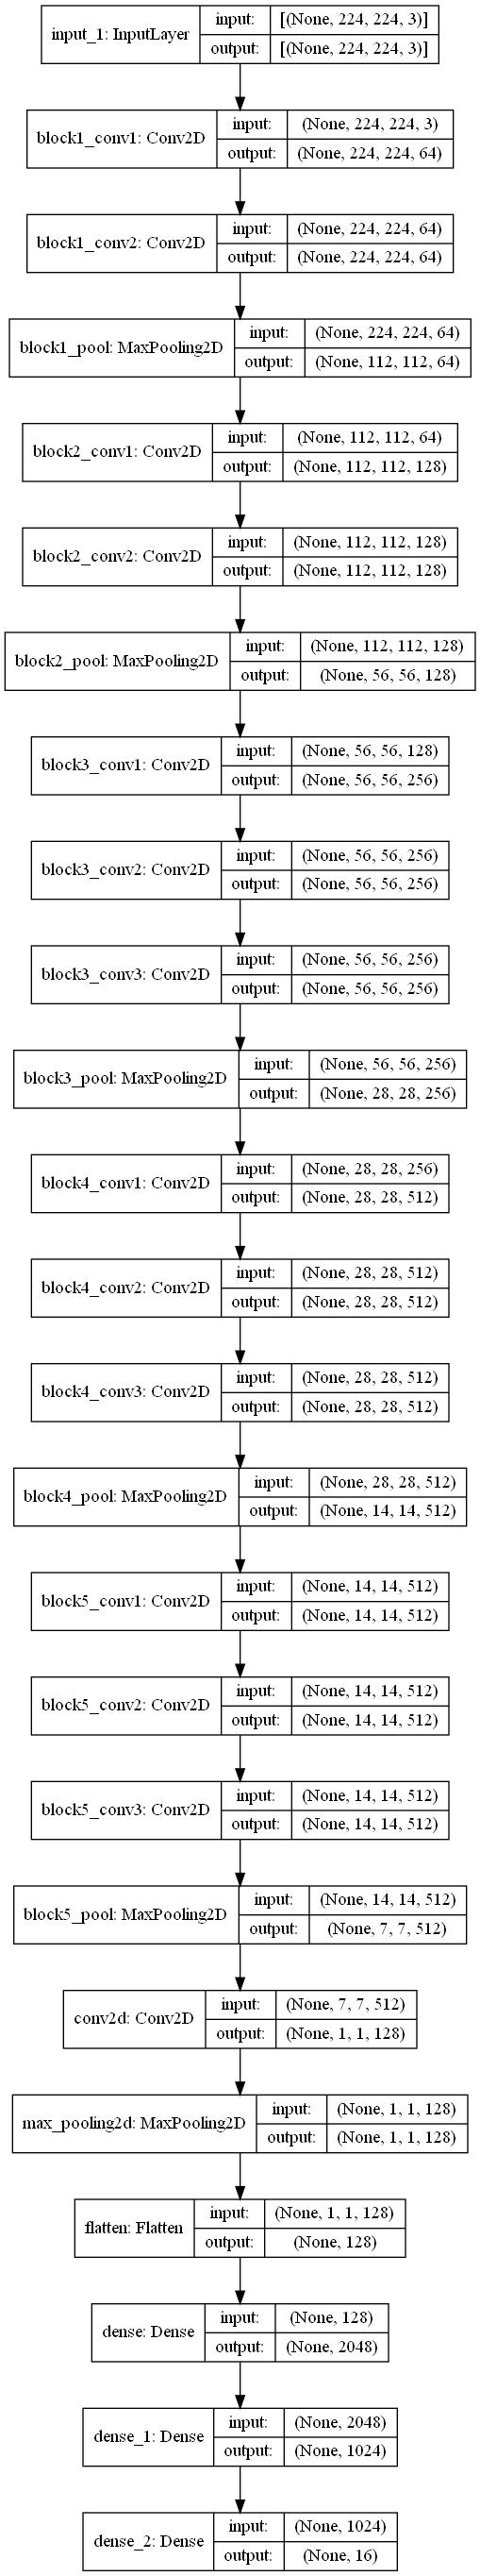

In [18]:
dot_img_file = 'image/model_1.png'
plot_model(final_model, to_file=dot_img_file, show_shapes=True)

In [19]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

## TENSORBOARD callback
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0001)

final_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

##fitting generator
final_model.fit_generator(train_generator,validation_data=valid_generator,epochs=15,callbacks=[tensorboard_callback])

Epoch 1/15
1125/1125 [==============================] - 1811s 2s/step - loss: 1.8097 - accuracy: 0.4201 - val_loss: 1.5897 - val_accuracy: 0.4987
Epoch 2/15
1125/1125 [==============================] - 1477s 1s/step - loss: 1.5472 - accuracy: 0.5099 - val_loss: 1.5169 - val_accuracy: 0.5219
Epoch 3/15
1125/1125 [==============================] - 1470s 1s/step - loss: 1.4625 - accuracy: 0.5362 - val_loss: 1.4782 - val_accuracy: 0.5279
Epoch 4/15
1125/1125 [==============================] - 1482s 1s/step - loss: 1.4134 - accuracy: 0.5514 - val_loss: 1.3858 - val_accuracy: 0.5609
Epoch 5/15
1125/1125 [==============================] - 1506s 1s/step - loss: 1.3708 - accuracy: 0.5647 - val_loss: 1.4540 - val_accuracy: 0.5421
Epoch 6/15
1125/1125 [==============================] - 2133s 2s/step - loss: 1.3474 - accuracy: 0.5743 - val_loss: 1.3593 - val_accuracy: 0.5688
Epoch 7/15
1125/1125 [==============================] - 1733s 2s/step - loss: 1.3142 - accuracy: 0.5827 - val_loss: 1.3789 -

In [31]:
%load_ext tensorboard

%tensorboard --logdir logs

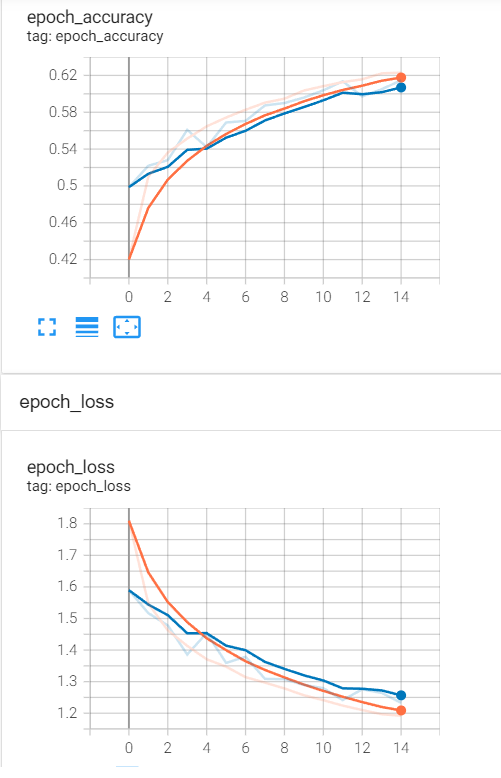

In [21]:
from IPython.display import Image
PATH = "D:/APPLIED AI/Assignments/Assignment 20 - Transfer Learning/Result_images/"

Image(filename = PATH + "model-1_acc_loss_.png", width=400, height=80)

In the above plot the orange line signifies the train set and blue line signifies the validation set.

Highest accuracy - 0.6230  
Lowest loss - 1.1921  

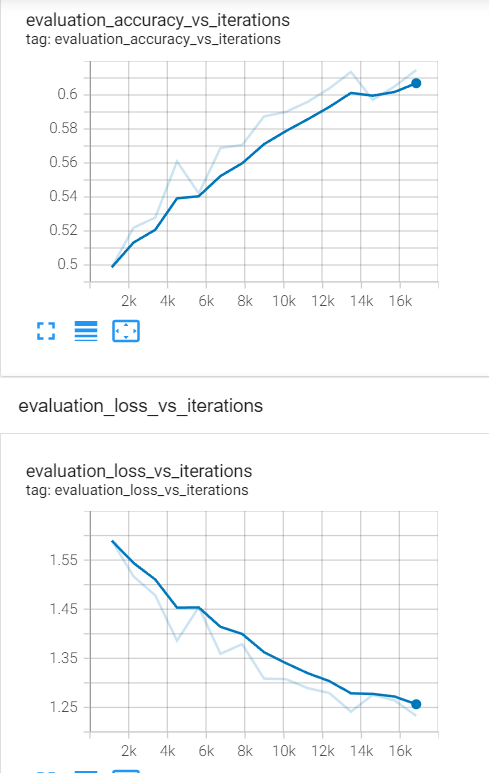

In [22]:
Image(filename = PATH + "model-1_acc_loss_vs_iter_.png", width=400, height=80)

From the above 2 plots, we see that the accuracy increases and loss decreases as the number of epochs and iterations increases.

### Model-2

<pre>
1. Use <a href='https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16'>VGG-16</a> pretrained network without Fully Connected layers and initilize all the weights with Imagenet trained weights.
2. After VGG-16 network without FC layers, don't use FC layers, use conv layers only as Fully connected layer. any FC layer can be converted to a CONV layer. This conversion will reduce the No of Trainable parameters in FC layers. For example, an FC layer with K=4096 that is looking at some input volume of size 7×7×512 can be equivalently expressed as a CONV layer with F=7,P=0,S=1,K=4096. In other words, we are setting the filter size to be exactly the size of the input volume, and hence the output will simply be 1×1×4096 since only a single depth column “fits” across the input volume, giving identical result as the initial FC layer. You can refer <a href='http://cs231n.github.io/convolutional-networks/#convert'>this</a> link to better understanding of using Conv layer in place of fully connected layers.
3. Final architecture will be VGG-16 without FC layers(without top), 2 Conv layers identical to FC layers, 1 output layer for 16 class classification. <b>INPUT --> VGG-16 without Top layers(FC) --> 2 Conv Layers identical to FC --> Output Layer</b>
3. Train only last 2 Conv layers identical to FC layers, 1 output layer. Don't train the VGG-16 network. 
</pre>

In [10]:


## Set the random seed values to regenerate the model.

## loading vgg16 model without FC layers
vgg16 = VGG16(weights='imagenet',include_top=False,input_shape = (224,224, 3))

## freezing the model
vgg16.trainable = False


vgg16_op = vgg16.output

## convolution layers as FC layers
conv_layer_1 = Conv2D(filters=4096, kernel_size=7, activation='relu',padding='valid')(vgg16_op)
conv_layer_2 = Conv2D(filters=4096, kernel_size=1, activation='relu',padding='valid')(conv_layer_1)

flatten = Flatten()(conv_layer_2)

output_layer_2 = Dense(16,activation='softmax')(flatten)

final_model_2 = Model(inputs = vgg16.input, outputs = output_layer_2)
final_model_2.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

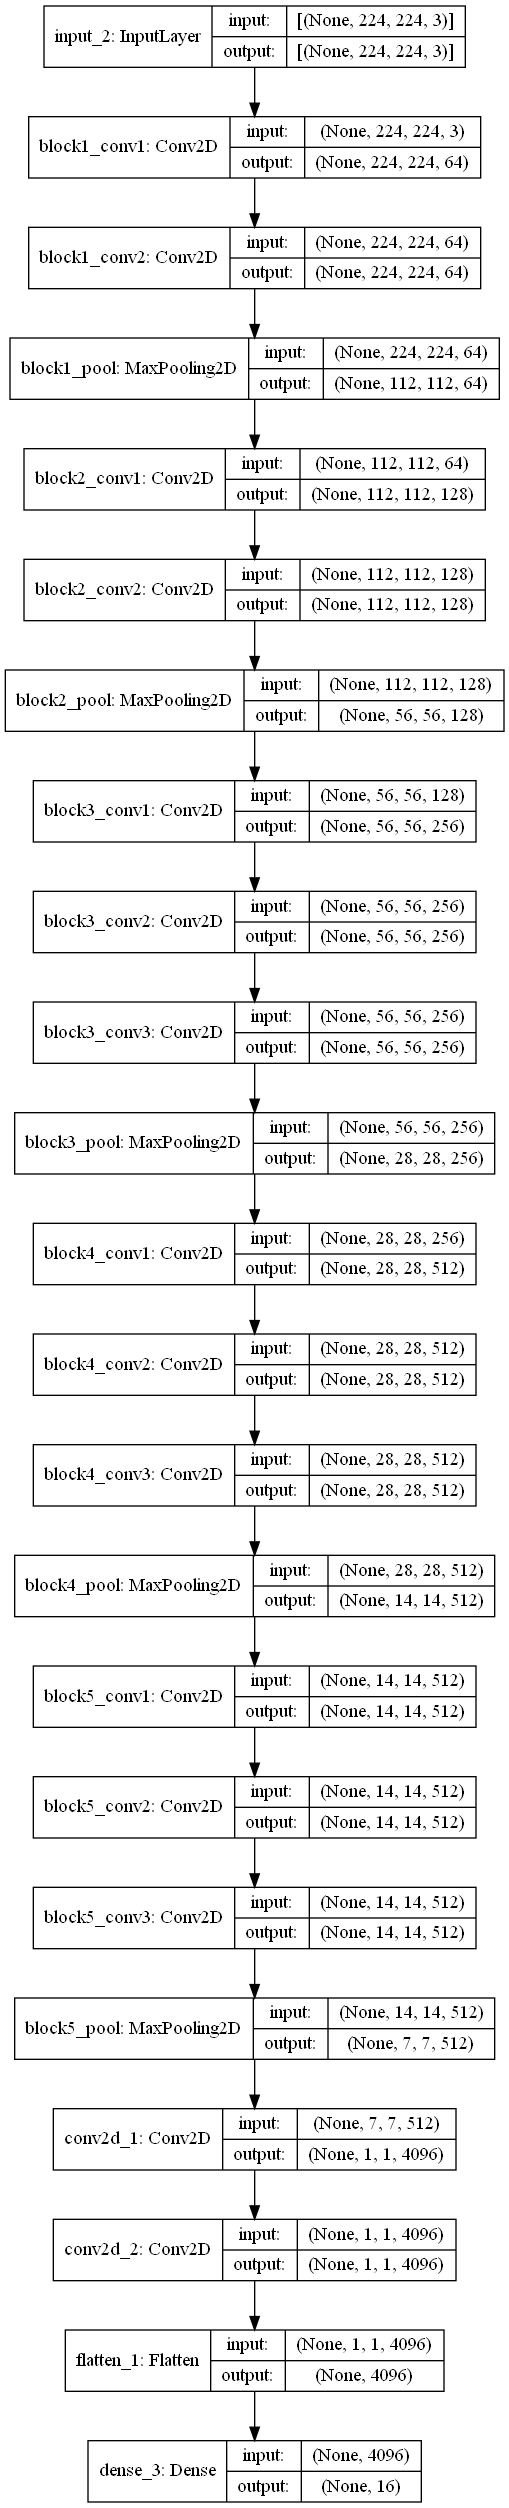

In [12]:
dot_img_file = 'image/model_2.png'
plot_model(final_model_2, to_file=dot_img_file, show_shapes=True)


In [18]:
## TENSORBOARD callback
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0001)

final_model_2.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

##fitting generator
final_model_2.fit_generator(train_generator,validation_data=valid_generator,epochs=7,callbacks=[tensorboard_callback])

Epoch 1/7
1125/1125 [==============================] - 2014s 2s/step - loss: 1.7742 - accuracy: 0.4372 - val_loss: 1.5856 - val_accuracy: 0.4985
Epoch 2/7
1125/1125 [==============================] - 2253s 2s/step - loss: 1.5123 - accuracy: 0.5242 - val_loss: 1.5223 - val_accuracy: 0.5229
Epoch 3/7
1125/1125 [==============================] - 2240s 2s/step - loss: 1.4136 - accuracy: 0.5571 - val_loss: 1.3792 - val_accuracy: 0.5686
Epoch 4/7
1125/1125 [==============================] - 2280s 2s/step - loss: 1.3467 - accuracy: 0.5795 - val_loss: 1.3572 - val_accuracy: 0.5766
Epoch 5/7
1125/1125 [==============================] - 2082s 2s/step - loss: 1.2933 - accuracy: 0.5944 - val_loss: 1.3444 - val_accuracy: 0.5844
Epoch 6/7
1125/1125 [==============================] - 2414s 2s/step - loss: 1.2503 - accuracy: 0.6067 - val_loss: 1.2515 - val_accuracy: 0.6143
Epoch 7/7
1125/1125 [==============================] - 2290s 2s/step - loss: 1.2230 - accuracy: 0.6184 - val_loss: 1.2579 - val_ac

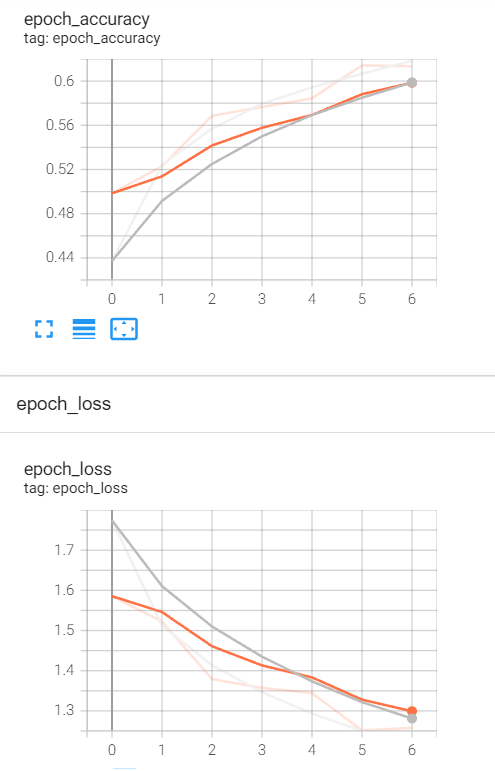

In [35]:
Image(filename = PATH + "model-2_acc_loss.png", width=400, height=80)

In the above plot the orange line signifies the validation set and grey line signifies the train set.

Hoghest accuracy - 0.6184 
Lowest loss - 1.2230 

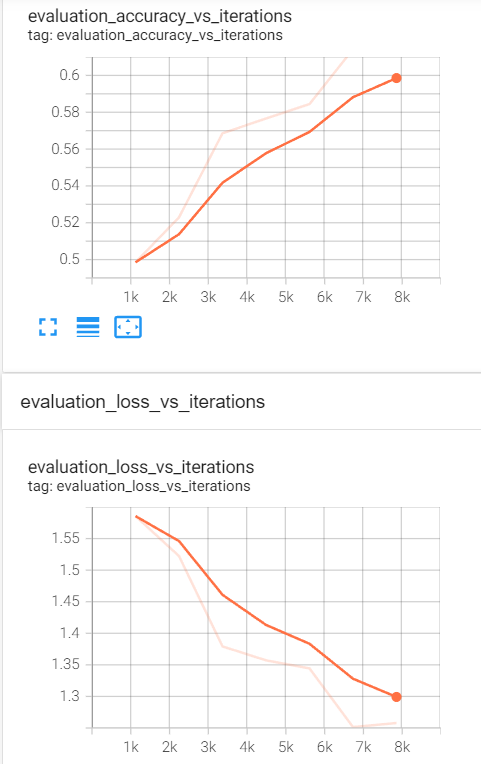

In [36]:
Image(filename = PATH + "model-2_acc_loss_vs_iter.png", width=400, height=80)

From the above 2 plots, we see that the accuracy increases and loss decreases as the number of epochs and iterations increases.

### Model-3

<pre>
1. Use same network as Model-2 '<b>INPUT --> VGG-16 without Top layers(FC) --> 2 Conv Layers identical to FC --> Output Layer</b>' and train only Last 6 Layers of VGG-16 network, 2 Conv layers identical to FC layers, 1 output layer.
</pre>

In [13]:

tf.keras.backend.clear_session()

np.random.seed(0)
rn.seed(0)


vgg16 = VGG16(weights='imagenet',include_top=False,input_shape = (224,224, 3))

## making only the last 6 layers of VGG16 as trainable
for l in vgg16.layers[:-6]:
    l.trainable=False


vgg16_op = vgg16.output
conv_layer_1 = Conv2D(filters=4096, kernel_size=7, activation='relu',padding='valid')(vgg16_op)
conv_layer_2 = Conv2D(filters=4096, kernel_size=1, activation='relu',padding='valid')(conv_layer_1)
flatten = Flatten()(conv_layer_2)
output_layer_3 = Dense(16,activation='softmax')(flatten)

final_model_3=Model(inputs = vgg16.input, outputs = output_layer_3)
final_model_3.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

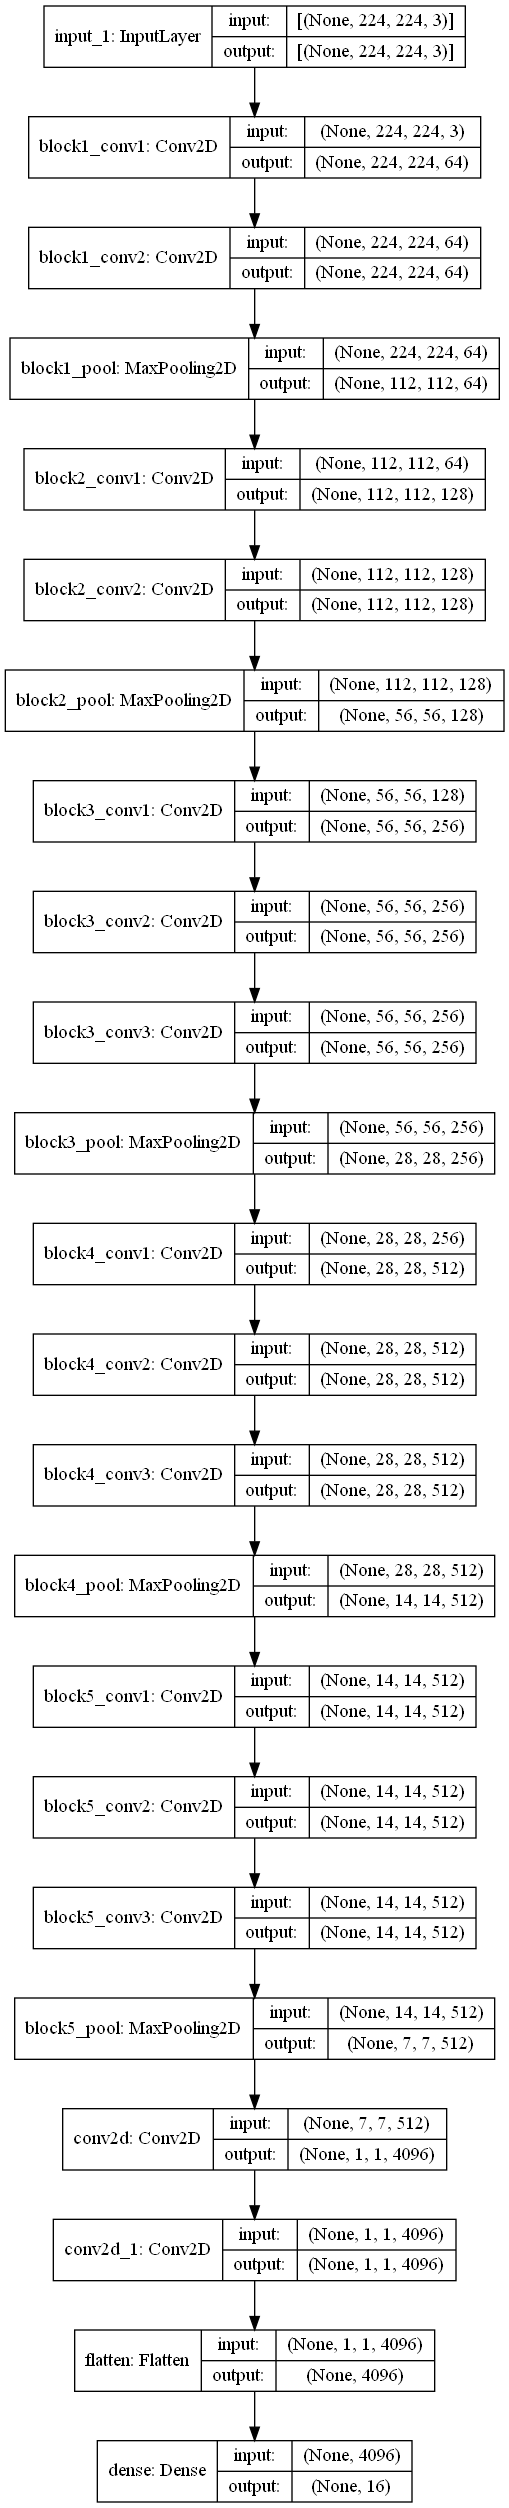

In [14]:
dot_img_file = 'image/model_3.png'
plot_model(final_model_3, to_file=dot_img_file, show_shapes=True)


In [26]:
## TENSORBOARD callback
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

optimizer =  tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.8)

final_model_3.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

##fitting generator
final_model_3.fit_generator(train_generator,steps_per_epoch=1125,validation_data=valid_generator,validation_steps=375,epochs=3,callbacks=[tensorboard_callback])

Epoch 1/3
1125/1125 [==============================] - 2256s 2s/step - loss: 1.6597 - accuracy: 0.4770 - val_loss: 1.4100 - val_accuracy: 0.5566
Epoch 2/3
1125/1125 [==============================] - 2203s 2s/step - loss: 1.3341 - accuracy: 0.5863 - val_loss: 1.2866 - val_accuracy: 0.6060
Epoch 3/3
1125/1125 [==============================] - 2362s 2s/step - loss: 1.1941 - accuracy: 0.6329 - val_loss: 1.2596 - val_accuracy: 0.6082


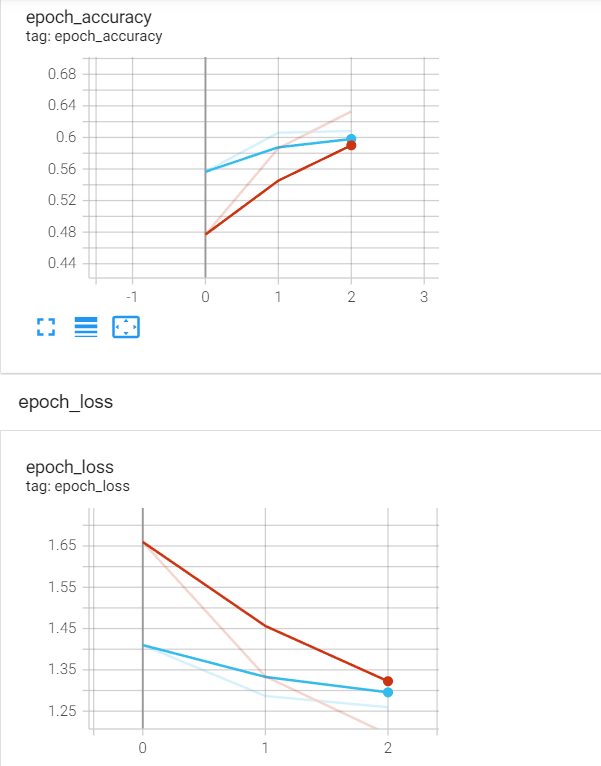

In [9]:
Image(filename = PATH + "model-3 acc-loss.png", width=400, height=80)

In the above plot the red line signifies the validation set and blue line signifies the train set

Highest accuracy - 0.6329 
Lowest loss - 1.1941 

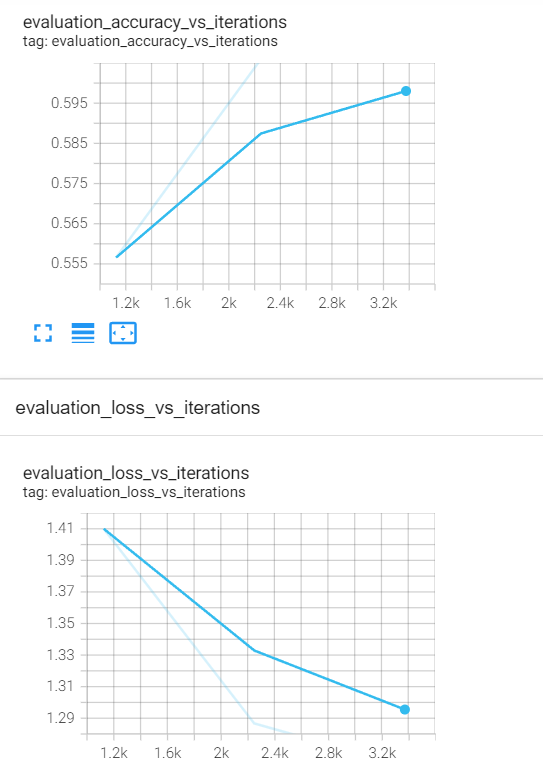

In [10]:
Image(filename = PATH + "model-3-acc_loss vs iter.png", width=400, height=80)

From the above 2 plots, we see that the accuracy increases and loss decreases as the number of epochs and iterations increases.

# OBSERVATIONS

Transfer Learning was performed with VGG16 model for 3 cases
1. VGG16 without the fully connected layers was freezed and the training was done only to the additional convolution,maxpooling and dense layers 
2. VGG16 without the fully connected layers was freezed and the training was done to the additional convolution layers(as fully connnected layers) and the output layer
3. VGG16 without the fully connected layers, except the bottom 6 layers, was freezed and training was done to the last 6 layers of 'VGG16 without FC layers' , the additional convolution layers and the output layer

For all the 3 models ,it was observed that the model accuracy increases and loss decreases as epoch increases

In [25]:
from prettytable import PrettyTable 
myTable = PrettyTable(['Model   ','Max_Train_Accuracy','Max_Validation_Accuracy'])
myTable.add_row(['Model-1','0.6230','0.6147'])
myTable.add_row(['Model-2','0.6184','0.6143'])
myTable.add_row(['Model-3','0.6329','0.6082'])
print(myTable)

+----------+--------------------+-------------------------+
| Model    | Max_Train_Accuracy | Max_Validation_Accuracy |
+----------+--------------------+-------------------------+
| Model-1  |       0.6230       |          0.6147         |
| Model-2  |       0.6184       |          0.6143         |
| Model-3  |       0.6329       |          0.6082         |
+----------+--------------------+-------------------------+
